# Notebook 1 - Exploring causal graphs and relationships (teacher notebook)

In this notebook we'll work through some basic examples of causal relationships, in the form of causal graphs.

__NOTE FOR WINDOWS USERS__: You may need to run the following lines in order for `graphviz` to work in this notebook:

```
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin\' # Or to whatever folder on your machine has the graphviz bin files
```

In [1]:
from causalgraphicalmodels.csm import StructuralCausalModel, linear_model, logistic_model
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, pearsonr

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def clean_corr(corr_results):
    """
    Takes the output of the scipy.stats.pearsonr function (Pearson correlation) and cleans it up for easy viewing
    
    Args:
        corr_results: Tuple of floats, the output from scipy.stats.pearsonr
        
    Returns: None
    """
    print(f"r = {round(corr_results[0], 3)} (p =  {round(corr_results[1], 3)})")

## Classic confounding

Let's begin by creating a simple causal model for confounding. Remember, a covariate confounds a relationship between two variables of interest when it causes both. This can induce a spurious association between these two variables if none truly exists.

In [3]:
# Create a toy model here for confounding. We can specify the relationships between three variables
cie_example = StructuralCausalModel({
    "smoking": lambda n_samples: np.random.binomial(1, p=0.30, size=n_samples), 
    "coffee": linear_model(["smoking"], [1.5]),
    "lung cancer risk": linear_model(["smoking"], [6])
})

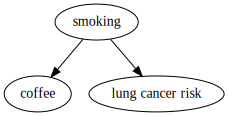

In [4]:
cie_cgm = cie_example.cgm
cie_cgm.draw()

In [5]:
data = cie_example.sample(n_samples=100000)
data.head()

,smoking,coffee,lung cancer risk
0,1,2.499054,5.998553
1,0,-0.528606,-0.155160
2,1,0.867596,5.936095
3,0,1.374822,0.817737
4,0,0.903608,0.523171


We can see that there is an apparent moderately strong, positive association between the coffee and lung cancer risk variables

In [6]:
clean_corr(
    pearsonr(data['coffee'], data['lung cancer risk'])
)

r = 0.532 (p =  0.0)


As a sanity check, let's plot the relationship between coffee and lung cancer risk

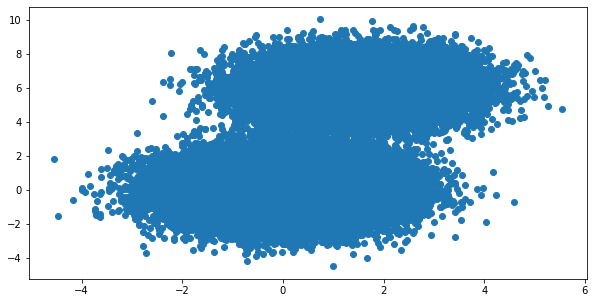

In [7]:
plt.scatter(data['coffee'], data['lung cancer risk'])

There's a lot of overlapping data there, so let's create a hexbin heatmap plot to better see what's going on here.

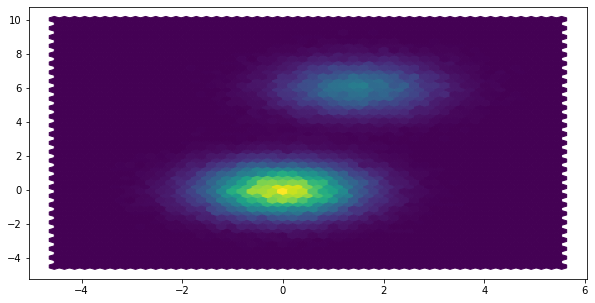

In [8]:
plt.hexbin(data['coffee'], data['lung cancer risk'], gridsize=50)

We can disrupt the confounding by stratifying on smoking. Let's filter the dataset so that we only consider smokers (we could just as easily restrict on non-smokers and this would work too)

In [9]:
data2 = data[data['smoking'] == 0]

After we do this, the association between coffee and lung cancer risk vanishes entirely!

In [10]:
clean_corr(
    pearsonr(data2['coffee'], data2['lung cancer risk'])
)

r = -0.002 (p =  0.634)


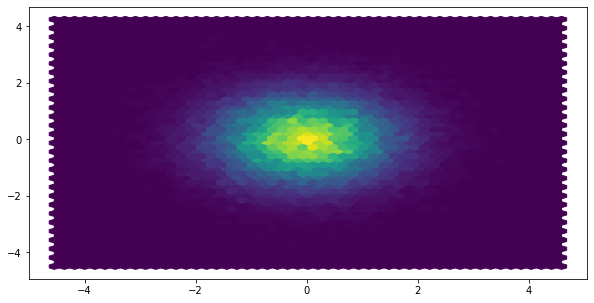

In [11]:
plt.hexbin(data2['coffee'], data2['lung cancer risk'], gridsize=50)

## Collider

Now let's consider a collider causal relationship. Controlling for a collider can induce a false association between two variables if you control / stratify on it. For the following exercise, there shouldn't be an association between your genetic risk of diabetes and your family's household income when you were a child.

In [12]:
cie_example = StructuralCausalModel({
    "your genetic risk of diabetes": lambda n_samples: np.random.normal(loc=1, scale=0.5, size=n_samples), 
    "household income during your childhood": lambda n_samples: np.random.normal(loc=3, scale=1, size=n_samples), 
    "mother's diabetes": logistic_model(["your genetic risk of diabetes", "household income during your childhood"], [1.5,-0.5])
})

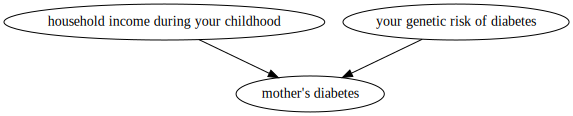

In [13]:
cie_cgm = cie_example.cgm
cie_cgm.draw()

In [14]:
data = cie_example.sample(n_samples=100000)
data.head()

,your genetic risk of diabetes,household income during your childhood,mother's diabetes
0,1.902457,4.887844,1
1,1.563093,4.676389,1
2,0.658647,3.574684,0
3,0.033963,2.123191,1
4,-0.096326,2.169424,0


<div class="alert alert-success">
    <h3>EXERCISE: determine the raw association between genetic risk of diabetes and household income during childhood</h3>
</div>

In [15]:
clean_corr(
    pearsonr(data['your genetic risk of diabetes'], data['household income during your childhood'])
)

r = 0.002 (p =  0.552)


Let's restrict the dataset to only those with high numbers of sick days taken. We've now stratified, controlled for a collider... bad idea.

In [16]:
data2 = data[data["mother's diabetes"] == 1]

<div class="alert alert-success">
    <h3>EXERCISE: Is there still zero association between genetic risk of diabetes and household income during childhood?</h3>
</div>

In [17]:
clean_corr(
    pearsonr(data2['your genetic risk of diabetes'], data2['household income during your childhood'])
)

r = 0.078 (p =  0.0)


## Mediation

<div class="alert alert-success">
    <h3>EXERCISE: Create a toy model demonstrating the causal relationship of "mediation". Here's a tip, in three variables you could show that smoking leads to clinical signs of lung damage, which in turn leads to lung cancer</h3>
</div>

In [18]:
cie_example = StructuralCausalModel({
    "smoking": lambda n_samples: np.random.normal(loc=0, scale=0.5, size=n_samples), 
    "signs of lung damage": logistic_model(["smoking"], [5]),
    "lung cancer": linear_model(["signs of lung damage"], [5]),
})

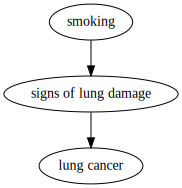

In [19]:
cie_cgm = cie_example.cgm
cie_cgm.draw()

In [20]:
data = cie_example.sample(n_samples=100000)
data.head()

,smoking,signs of lung damage,lung cancer
0,-0.086094,0,1.533719
1,0.752166,1,4.311678
2,0.389148,1,5.463878
3,-0.527347,0,0.719327
4,-0.250108,0,-0.361790


<div class="alert alert-success">
    <h3>EXERCISE: Can you demonstrate that there is a relationship between the two outer variables (that are mediated by a third variable)?</h3>
</div>

In [21]:
clean_corr(
    pearsonr(data['smoking'], data['lung cancer'])
)

r = 0.608 (p =  0.0)


<div class="alert alert-success">
    <h3>EXERCISE: Try restricting the mediator in this dataset. Basically, filter the dataset so there is no variability in the mediator, and then you have broken the relationship between the two outer variables!</h3>
</div>

In [22]:
data2 = data[data['signs of lung damage'] == 1]

<div class="alert alert-success">
    <h3>EXERCISE: Can you confirm that the relationship between smoking and cancer has been broken?</h3>
</div>

In [23]:
clean_corr(
    pearsonr(data2['smoking'], data2['lung cancer'])
)

r = 0.0 (p =  0.936)


## Unrelated predictors

<div class="alert alert-success">
    <h3>EXERCISE: Are you following the basic workflow we've been using above? Try to replicate it to show the causal relationship of an "unrelated predictor". This is a variable that causes some outcome, but is completely unrelated to a variable you're interested in. Because of this, stratifying / controlling for this unrelated predictor doesn't alter the relationship between your variable of interest and the outcome.</h3>
</div>

In [24]:
cie_example = StructuralCausalModel({
    "leg injury": lambda n_samples: np.random.normal(loc=0, scale=0.5, size=n_samples), 
    "unsafe neighborhood": lambda n_samples: np.random.binomial(1, p=0.40, size=n_samples), 
    "lack of exercise": logistic_model(["leg injury", "unsafe neighborhood"], [1, 0.5]),
    "genetic risk of diabetes": lambda n_samples: np.random.binomial(1, p=0.70, size=n_samples), 
    "diabetes risk": linear_model(["lack of exercise", "genetic risk of diabetes"], [0.5, -0.4])
})

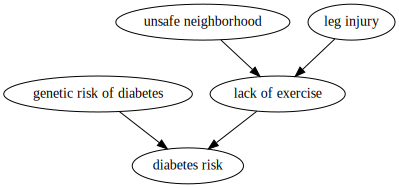

In [25]:
cie_cgm = cie_example.cgm
cie_cgm.draw()

In [26]:
data = cie_example.sample(n_samples=100000)
data.head()

,leg injury,unsafe neighborhood,genetic risk of diabetes,lack of exercise,diabetes risk
0,-0.447457,0,0,0,-0.514775
1,-0.642453,0,1,0,0.604133
2,-0.329178,1,0,1,1.816957
3,-0.307560,0,1,1,0.811910
4,0.622401,1,1,1,-0.204837


In [27]:
clean_corr(
    pearsonr(data['lack of exercise'], data['diabetes risk'])
)

r = 0.24 (p =  0.0)


In [28]:
data2 = data[data['genetic risk of diabetes'] == 1]

In [29]:
clean_corr(
    pearsonr(data2['lack of exercise'], data2['diabetes risk'])
)

r = 0.244 (p =  0.0)
